Here we fit models across fish, looking at the latent representations of different conditions for all fish in the same 
low-d space

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from itertools import chain
from pathlib import Path

from matplotlib import cm
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import svd
import torch

import sklearn.decomposition as decomposition

from ahrens_wbo.annotations import label_subperiods
from ahrens_wbo.data_processing import load_and_preprocess_data
from janelia_core.ml.utils import list_torch_devices
from janelia_core.visualization.image_generation import max_project_pts
from janelia_core.visualization.image_generation import generate_dot_image_3d
from janelia_core.visualization.image_generation import scalar_3d_max_project
from janelia_core.visualization.matrix_visualization import cmp_n_mats
from probabilistic_model_synthesis.fa import FAMdl
from probabilistic_model_synthesis.fa import Fitter
from probabilistic_model_synthesis.fa import generate_basic_posteriors
from probabilistic_model_synthesis.fa import generate_hypercube_prior_collection
from probabilistic_model_synthesis.fa import generate_simple_prior_collection
from probabilistic_model_synthesis.fa import initialize_basic_posteriors
from probabilistic_model_synthesis.fa import orthonormalize
from probabilistic_model_synthesis.fa import VICollection

In [3]:
%matplotlib notebook

## Parameters go here

In [4]:
ps = dict()

# Specify the directory where all the raw data is found
ps['data_dir'] = r'/groups/bishop/bishoplab/projects/ahrens_wbo/data'

# Here we list the subject we want to fit and the conditions we want to fit on for each subject
ps['fit_specs'] = {8: ['omr_forward', 'omr_left', 'omr_right'], 
                   9: ['omr_forward', 'omr_left', 'omr_right'], 
                   10: ['omr_forward', 'omr_left', 'omr_right'], 
                   11: ['omr_forward', 'omr_left', 'omr_right']} 


#ps['fit_specs'] = {1: ['phototaxis_left', 'phototaxis_right'],
#                   2: ['phototaxis_left', 'phototaxis_right'],
#                   5: ['phototaxis_left', 'phototaxis_right'],
#                   6: ['phototaxis_left', 'phototaxis_right'], 
#                   8: ['phototaxis_left', 'phototaxis_right'],
#                   9: ['phototaxis_left', 'phototaxis_right'],
#                   10: ['phototaxis_left', 'phototaxis_right'],
#                   11: ['phototaxis_left', 'phototaxis_right']}
                   
                   
# Here we specify if we fit in conditions with shock or not
ps['shock'] = False

# Specify the number of latent variables in the FA models
ps['n_latent_vars'] = 10

## Load the data for each subject

In [5]:
datasets, neuron_locs = load_and_preprocess_data(data_folder=ps['data_dir'], 
                                    subjects=list(ps['fit_specs'].keys()), 
                                                 neural_gain=10)

Done loading data for subject subject_8.
Done loading data for subject subject_9.
Done loading data for subject subject_10.
Done loading data for subject subject_11.


## Form the fitting data for each subject

In [6]:
all_subperiods = set(chain(*[v for v in ps['fit_specs'].values()]))
label_map = {sp: sp_i for sp_i, sp in enumerate(all_subperiods)}

In [7]:
fit_data = dict()
fit_labels = dict()
for s_n, dataset in datasets.items():
    
    data_n = datasets[s_n].ts_data['dff']['vls'][:]
    
    # Label the subperiods for this subject
    subperiods = label_subperiods(dataset.ts_data['stim']['vls'][:])
    
    # Down select to only the subperiods we want to fit on for this subject
    subperiods = {k:v for k, v in subperiods.items() if k in ps['fit_specs'][s_n]}
    
    # Down select to the shock condition we want to fit
    subperiods = {k: [sp_i for sp_i in v if sp_i['shock'] == ps['shock']] for k, v in subperiods.items()} 
    
    # Pull out the fitting data for this subject
    fit_data[s_n] = {k:np.concatenate([data_n[sl['slice'], :] for sl in v], axis=0) for k, v in subperiods.items()}
    
    # Generate numerical labels for each data point
    fit_labels[s_n] = {k:label_map[k]*np.ones(np.sum([sl_i['slice'].stop - sl_i['slice'].start for sl_i in v])) 
                   for k, v in subperiods.items()}
    

In [8]:
fit_data_conc = {k: np.concatenate([data for data in v.values()], axis=0) for k, v in fit_data.items()}
fit_labels_conc = {k: np.concatenate([lbls for lbls in v.values()], axis=0) for k, v in fit_labels.items()}

## Setup everything for fitting FA models together

In [38]:
fit_priors = generate_hypercube_prior_collection(n_latent_vars=ps['n_latent_vars'], 
                                                 hc_params={'n_divisions_per_dim': [20, 20, 10], 
                                                            'dim_ranges': np.asarray([[0, 990.0], 
                                                                                      [0, 610.0], 
                                                                                      [0, 350.0]]),
                                                            'n_div_per_hc_side_per_dim': [1, 1, 1]}, 
                                                 lm_mn_init=0.0,
                                                 lm_std_init=1.0, 
                                                 mn_mn_init=0.0, 
                                                 mn_std_init=1.0, 
                                                 psi_conc_vl_init=.2,
                                                 psi_rate_vl_init=.1,
                                                 min_gamma_conc_vl=.1,
                                                 min_gamma_rate_vl=.000001)
                                                 

fit_posteriors = generate_basic_posteriors(n_obs_vars=[data_n.shape[1] for data_n in fit_data_conc.values()],
                                           n_smps=[data_n.shape[0] for data_n in fit_data_conc.values()],
                                           n_latent_vars=ps['n_latent_vars'], 
                                           mn_opts={'std_ub': 10000.0}, 
                                           lm_opts={'std_ub': 10000.0},
                                           psi_opts={'alpha_lb': .1, 'beta_lb': .000001})

fit_posteriors = {k: fit_posteriors[k_i] for k_i, k in enumerate(fit_data_conc.keys())}


fit_mdls = {k:FAMdl(lm=None, #torch.zeros(data_n.shape[1], ps['n_latent_vars']), 
                    mn=None, #torch.zeros(data_n.shape[1]),
                    psi=None) for k, data_n in fit_data_conc.items()} #.01*torch.ones(data_n.shape[1]))
                    
                    
                   
vi_collections = [VICollection(data=torch.tensor(fit_data_conc[s_n]), 
                               props=neuron_locs[s_n],
                               mdl = fit_mdls[s_n],
                               posteriors = fit_posteriors[s_n])
                               for s_i, s_n in enumerate(fit_data_conc.keys())]


## Initialize posteriors

In [10]:
subjects = list(ps['fit_specs'].keys())
initialize_basic_posteriors(posteriors=[fit_posteriors[s_n] for s_n in subjects],
                                  data=[fit_data_conc[s_n] for s_n in subjects])

Done initializing posteriors for model 1 of 4.
Done initializing posteriors for model 2 of 4.
Done initializing posteriors for model 3 of 4.
Done initializing posteriors for model 4 of 4.


## Initialize priors

In [11]:
devices, _ = list_torch_devices()

Found 1 GPUs


In [12]:
fitter = Fitter(vi_collections=vi_collections, priors=fit_priors)

In [13]:
fitter.distribute(distribute_data=True, devices=devices)

In [14]:
prior_opt_log = fitter.optimize_priors(1000, milestones=[500, 700], update_int=100, init_lr=.01)


=========== EPOCH 0 COMPLETE ===========
Obj: 2.10e+07
----------------------------------------
LM KL: 3.68e+06, 4.08e+06, 4.34e+06, 5.61e+06
Mn KL: 3.36e+05, 3.77e+05, 3.88e+05, 4.72e+05
Psi KL: 3.72e+05, 4.15e+05, 4.36e+05, 5.08e+05
----------------------------------------
LR: 0.01
Elapsed time (secs): 0.24623894691467285
----------------------------------------
CPU cur memory used (GB): 3.17e+01
GPU_0 cur memory used (GB): 9.65e-01, max memory used (GB): 9.65e-01

=========== EPOCH 100 COMPLETE ===========
Obj: 1.02e+07
----------------------------------------
LM KL: 1.61e+06, 1.73e+06, 1.87e+06, 2.72e+06
Mn KL: 1.44e+05, 1.47e+05, 1.50e+05, 5.14e+05
Psi KL: 2.74e+05, 3.06e+05, 3.26e+05, 3.80e+05
----------------------------------------
LR: 0.01
Elapsed time (secs): 15.38411545753479
----------------------------------------
CPU cur memory used (GB): 3.17e+01
GPU_0 cur memory used (GB): 9.65e-01, max memory used (GB): 9.65e-01

=========== EPOCH 200 COMPLETE ===========
Obj: 8.20e+0

#### Look at log for prior optimizatiom

[True, False, False, True, True, True]


<IPython.core.display.Javascript object>


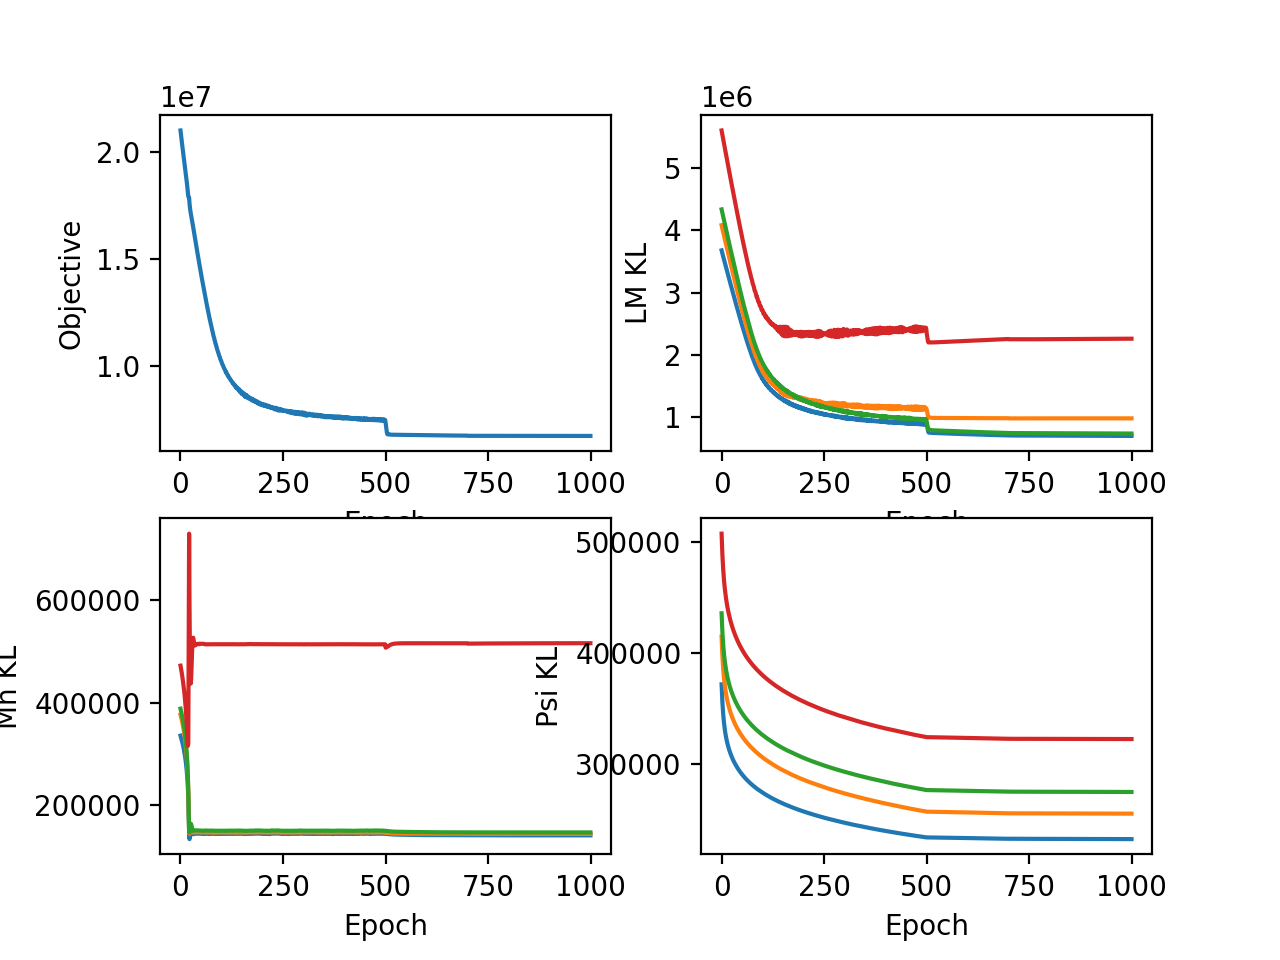

In [15]:
fitter.plot_log(prior_opt_log)

## Fit the models together

In [39]:
fitter.distribute(distribute_data=True, devices=devices)

In [40]:
log = fitter.fit(500, milestones=[300, 500, 700], update_int=2, init_lr=.1, 
                 skip_lm_kl=False, skip_mn_kl=False, skip_psi_kl=False)


=========== EPOCH 0 COMPLETE ===========
Obj: 3.83e+08
----------------------------------------
NELL: 1.93e+08, 6.03e+07, 4.45e+07, 7.25e+07
Latent KL: 5.12e+04, 1.53e+04, 1.17e+04, 1.65e+04
LM KL: 2.86e+06, 2.15e+06, 2.23e+06, 3.14e+06
Mn KL: 2.83e+05, 2.57e+05, 2.81e+05, 3.76e+05
Psi KL: 2.09e+05, 1.87e+05, 2.03e+05, 2.51e+05
----------------------------------------
LR: 0.1
Elapsed time (secs): 0.3894336223602295
----------------------------------------
CPU cur memory used (GB): 3.35e+01
GPU_0 cur memory used (GB): 1.01e+00, max memory used (GB): 1.01e+00

=========== EPOCH 2 COMPLETE ===========
Obj: 3.79e+08
----------------------------------------
NELL: 1.91e+08, 6.06e+07, 4.46e+07, 7.27e+07
Latent KL: 3.97e+04, 9.46e+03, 7.61e+03, 1.07e+04
LM KL: 2.52e+06, 1.83e+06, 1.89e+06, 2.65e+06
Mn KL: 1.93e+05, 1.79e+05, 1.80e+05, 2.23e+05
Psi KL: 2.09e+05, 1.87e+05, 2.03e+05, 2.51e+05
----------------------------------------
LR: 0.1
Elapsed time (secs): 1.1545300483703613
---------------


=========== EPOCH 30 COMPLETE ===========
Obj: 3.54e+08
----------------------------------------
NELL: 1.80e+08, 5.74e+07, 4.13e+07, 6.82e+07
Latent KL: 5.59e+04, 1.48e+04, 1.19e+04, 1.74e+04
LM KL: 1.62e+06, 1.18e+06, 1.17e+06, 1.37e+06
Mn KL: 2.08e+05, 1.95e+05, 1.99e+05, 2.44e+05
Psi KL: 2.11e+05, 1.83e+05, 1.98e+05, 2.48e+05
----------------------------------------
LR: 0.1
Elapsed time (secs): 11.72610330581665
----------------------------------------
CPU cur memory used (GB): 3.35e+01
GPU_0 cur memory used (GB): 1.01e+00, max memory used (GB): 1.01e+00

=========== EPOCH 32 COMPLETE ===========
Obj: 3.54e+08
----------------------------------------
NELL: 1.80e+08, 5.74e+07, 4.12e+07, 6.82e+07
Latent KL: 5.72e+04, 1.64e+04, 1.35e+04, 1.79e+04
LM KL: 1.62e+06, 1.18e+06, 1.17e+06, 1.36e+06
Mn KL: 2.08e+05, 1.94e+05, 1.98e+05, 2.42e+05
Psi KL: 2.11e+05, 1.82e+05, 1.98e+05, 2.48e+05
----------------------------------------
LR: 0.1
Elapsed time (secs): 12.479839563369751
--------------


=========== EPOCH 60 COMPLETE ===========
Obj: 3.52e+08
----------------------------------------
NELL: 1.79e+08, 5.69e+07, 4.12e+07, 6.80e+07
Latent KL: 6.99e+04, 1.72e+04, 1.24e+04, 1.78e+04
LM KL: 1.63e+06, 1.22e+06, 1.14e+06, 1.32e+06
Mn KL: 2.08e+05, 1.93e+05, 1.96e+05, 2.39e+05
Psi KL: 2.13e+05, 1.79e+05, 1.95e+05, 2.46e+05
----------------------------------------
LR: 0.1
Elapsed time (secs): 23.071709394454956
----------------------------------------
CPU cur memory used (GB): 3.35e+01
GPU_0 cur memory used (GB): 1.01e+00, max memory used (GB): 1.01e+00

=========== EPOCH 62 COMPLETE ===========
Obj: 3.52e+08
----------------------------------------
NELL: 1.79e+08, 5.69e+07, 4.12e+07, 6.80e+07
Latent KL: 7.01e+04, 1.70e+04, 1.29e+04, 1.90e+04
LM KL: 1.63e+06, 1.21e+06, 1.14e+06, 1.32e+06
Mn KL: 2.08e+05, 1.93e+05, 1.96e+05, 2.39e+05
Psi KL: 2.13e+05, 1.79e+05, 1.94e+05, 2.46e+05
----------------------------------------
LR: 0.1
Elapsed time (secs): 23.829776287078857
-------------


=========== EPOCH 90 COMPLETE ===========
Obj: 3.52e+08
----------------------------------------
NELL: 1.78e+08, 5.67e+07, 4.14e+07, 6.80e+07
Latent KL: 7.01e+04, 1.90e+04, 1.11e+04, 1.70e+04
LM KL: 1.60e+06, 1.19e+06, 1.14e+06, 1.29e+06
Mn KL: 2.08e+05, 1.93e+05, 1.95e+05, 2.39e+05
Psi KL: 2.15e+05, 1.76e+05, 1.91e+05, 2.45e+05
----------------------------------------
LR: 0.1
Elapsed time (secs): 34.3575496673584
----------------------------------------
CPU cur memory used (GB): 3.35e+01
GPU_0 cur memory used (GB): 1.01e+00, max memory used (GB): 1.01e+00

=========== EPOCH 92 COMPLETE ===========
Obj: 3.52e+08
----------------------------------------
NELL: 1.78e+08, 5.68e+07, 4.13e+07, 6.80e+07
Latent KL: 6.99e+04, 1.76e+04, 1.20e+04, 1.86e+04
LM KL: 1.59e+06, 1.19e+06, 1.14e+06, 1.29e+06
Mn KL: 2.08e+05, 1.93e+05, 1.95e+05, 2.39e+05
Psi KL: 2.15e+05, 1.76e+05, 1.91e+05, 2.45e+05
----------------------------------------
LR: 0.1
Elapsed time (secs): 35.109901666641235
---------------


=========== EPOCH 120 COMPLETE ===========
Obj: 3.53e+08
----------------------------------------
NELL: 1.79e+08, 5.69e+07, 4.13e+07, 6.88e+07
Latent KL: 6.42e+04, 1.63e+04, 1.20e+04, 1.79e+04
LM KL: 1.57e+06, 1.22e+06, 1.17e+06, 1.50e+06
Mn KL: 2.08e+05, 1.94e+05, 1.95e+05, 2.39e+05
Psi KL: 2.17e+05, 1.73e+05, 1.89e+05, 2.44e+05
----------------------------------------
LR: 0.1
Elapsed time (secs): 45.70263743400574
----------------------------------------
CPU cur memory used (GB): 3.35e+01
GPU_0 cur memory used (GB): 1.01e+00, max memory used (GB): 1.01e+00

=========== EPOCH 122 COMPLETE ===========
Obj: 3.53e+08
----------------------------------------
NELL: 1.79e+08, 5.68e+07, 4.15e+07, 6.86e+07
Latent KL: 5.69e+04, 1.74e+04, 1.18e+04, 1.70e+04
LM KL: 1.57e+06, 1.22e+06, 1.18e+06, 1.46e+06
Mn KL: 2.08e+05, 1.94e+05, 1.96e+05, 2.39e+05
Psi KL: 2.17e+05, 1.73e+05, 1.89e+05, 2.44e+05
----------------------------------------
LR: 0.1
Elapsed time (secs): 46.46630573272705
-------------


=========== EPOCH 150 COMPLETE ===========
Obj: 3.53e+08
----------------------------------------
NELL: 1.79e+08, 5.67e+07, 4.14e+07, 6.87e+07
Latent KL: 5.91e+04, 1.77e+04, 1.22e+04, 1.45e+04
LM KL: 1.64e+06, 1.15e+06, 1.19e+06, 1.34e+06
Mn KL: 2.09e+05, 1.94e+05, 1.96e+05, 2.39e+05
Psi KL: 2.19e+05, 1.71e+05, 1.87e+05, 2.44e+05
----------------------------------------
LR: 0.1
Elapsed time (secs): 57.07342863082886
----------------------------------------
CPU cur memory used (GB): 3.35e+01
GPU_0 cur memory used (GB): 1.01e+00, max memory used (GB): 1.01e+00

=========== EPOCH 152 COMPLETE ===========
Obj: 3.52e+08
----------------------------------------
NELL: 1.79e+08, 5.67e+07, 4.13e+07, 6.85e+07
Latent KL: 5.75e+04, 1.89e+04, 1.23e+04, 1.30e+04
LM KL: 1.64e+06, 1.15e+06, 1.19e+06, 1.35e+06
Mn KL: 2.09e+05, 1.94e+05, 1.96e+05, 2.39e+05
Psi KL: 2.19e+05, 1.71e+05, 1.87e+05, 2.43e+05
----------------------------------------
LR: 0.1
Elapsed time (secs): 57.825777769088745
------------


=========== EPOCH 180 COMPLETE ===========
Obj: 3.52e+08
----------------------------------------
NELL: 1.79e+08, 5.72e+07, 4.10e+07, 6.80e+07
Latent KL: 5.79e+04, 1.66e+04, 1.36e+04, 1.65e+04
LM KL: 1.59e+06, 1.13e+06, 1.12e+06, 1.38e+06
Mn KL: 2.09e+05, 1.94e+05, 1.96e+05, 2.39e+05
Psi KL: 2.20e+05, 1.69e+05, 1.85e+05, 2.43e+05
----------------------------------------
LR: 0.1
Elapsed time (secs): 68.54332542419434
----------------------------------------
CPU cur memory used (GB): 3.35e+01
GPU_0 cur memory used (GB): 1.01e+00, max memory used (GB): 1.01e+00

=========== EPOCH 182 COMPLETE ===========
Obj: 3.67e+08
----------------------------------------
NELL: 1.94e+08, 5.70e+07, 4.11e+07, 6.80e+07
Latent KL: 4.90e+04, 1.61e+04, 1.27e+04, 1.60e+04
LM KL: 1.59e+06, 1.14e+06, 1.12e+06, 1.38e+06
Mn KL: 2.09e+05, 1.94e+05, 1.96e+05, 2.39e+05
Psi KL: 2.21e+05, 1.69e+05, 1.85e+05, 2.43e+05
----------------------------------------
LR: 0.1
Elapsed time (secs): 69.30585598945618
-------------


=========== EPOCH 210 COMPLETE ===========
Obj: 3.54e+08
----------------------------------------
NELL: 1.80e+08, 5.70e+07, 4.12e+07, 6.79e+07
Latent KL: 5.61e+04, 1.57e+04, 1.15e+04, 1.73e+04
LM KL: 2.25e+06, 1.17e+06, 1.20e+06, 1.35e+06
Mn KL: 2.10e+05, 1.94e+05, 1.96e+05, 2.39e+05
Psi KL: 2.22e+05, 1.68e+05, 1.83e+05, 2.43e+05
----------------------------------------
LR: 0.1
Elapsed time (secs): 79.92573356628418
----------------------------------------
CPU cur memory used (GB): 3.35e+01
GPU_0 cur memory used (GB): 1.01e+00, max memory used (GB): 1.01e+00

=========== EPOCH 212 COMPLETE ===========
Obj: 3.55e+08
----------------------------------------
NELL: 1.80e+08, 5.81e+07, 4.11e+07, 6.78e+07
Latent KL: 5.31e+04, 1.44e+04, 1.27e+04, 1.74e+04
LM KL: 2.19e+06, 1.17e+06, 1.19e+06, 1.35e+06
Mn KL: 2.10e+05, 1.94e+05, 1.96e+05, 2.39e+05
Psi KL: 2.22e+05, 1.67e+05, 1.83e+05, 2.43e+05
----------------------------------------
LR: 0.1
Elapsed time (secs): 80.6836416721344
--------------


=========== EPOCH 240 COMPLETE ===========
Obj: 3.53e+08
----------------------------------------
NELL: 1.78e+08, 5.70e+07, 4.24e+07, 6.77e+07
Latent KL: 6.17e+04, 1.69e+04, 1.09e+04, 1.73e+04
LM KL: 1.81e+06, 1.23e+06, 1.48e+06, 1.30e+06
Mn KL: 2.08e+05, 1.94e+05, 1.98e+05, 2.40e+05
Psi KL: 2.24e+05, 1.66e+05, 1.82e+05, 2.43e+05
----------------------------------------
LR: 0.1
Elapsed time (secs): 91.26069760322571
----------------------------------------
CPU cur memory used (GB): 3.35e+01
GPU_0 cur memory used (GB): 1.01e+00, max memory used (GB): 1.01e+00

=========== EPOCH 242 COMPLETE ===========
Obj: 3.53e+08
----------------------------------------
NELL: 1.78e+08, 5.70e+07, 4.22e+07, 6.77e+07
Latent KL: 6.02e+04, 1.57e+04, 1.15e+04, 1.84e+04
LM KL: 1.80e+06, 1.21e+06, 1.45e+06, 1.30e+06
Mn KL: 2.09e+05, 1.94e+05, 1.98e+05, 2.39e+05
Psi KL: 2.24e+05, 1.66e+05, 1.82e+05, 2.43e+05
----------------------------------------
LR: 0.1
Elapsed time (secs): 92.0114495754242
--------------


=========== EPOCH 270 COMPLETE ===========
Obj: 3.53e+08
----------------------------------------
NELL: 1.78e+08, 5.70e+07, 4.26e+07, 6.78e+07
Latent KL: 6.67e+04, 1.56e+04, 1.17e+04, 1.75e+04
LM KL: 1.74e+06, 1.19e+06, 1.22e+06, 1.38e+06
Mn KL: 2.09e+05, 1.95e+05, 1.97e+05, 2.40e+05
Psi KL: 2.25e+05, 1.65e+05, 1.81e+05, 2.43e+05
----------------------------------------
LR: 0.1
Elapsed time (secs): 102.54229974746704
----------------------------------------
CPU cur memory used (GB): 3.35e+01
GPU_0 cur memory used (GB): 1.01e+00, max memory used (GB): 1.01e+00

=========== EPOCH 272 COMPLETE ===========
Obj: 3.52e+08
----------------------------------------
NELL: 1.78e+08, 5.69e+07, 4.24e+07, 6.77e+07
Latent KL: 6.72e+04, 1.68e+04, 1.03e+04, 1.75e+04
LM KL: 1.73e+06, 1.20e+06, 1.21e+06, 1.38e+06
Mn KL: 2.09e+05, 1.95e+05, 1.98e+05, 2.40e+05
Psi KL: 2.25e+05, 1.65e+05, 1.81e+05, 2.43e+05
----------------------------------------
LR: 0.1
Elapsed time (secs): 103.29276990890503
-----------


=========== EPOCH 300 COMPLETE ===========
Obj: 3.50e+08
----------------------------------------
NELL: 1.78e+08, 5.67e+07, 4.09e+07, 6.74e+07
Latent KL: 7.02e+04, 1.76e+04, 1.45e+04, 2.13e+04
LM KL: 1.67e+06, 1.16e+06, 1.20e+06, 1.28e+06
Mn KL: 2.08e+05, 1.94e+05, 1.97e+05, 2.39e+05
Psi KL: 2.27e+05, 1.64e+05, 1.80e+05, 2.43e+05
----------------------------------------
LR: 0.010000000000000002
Elapsed time (secs): 113.80050230026245
----------------------------------------
CPU cur memory used (GB): 3.35e+01
GPU_0 cur memory used (GB): 1.01e+00, max memory used (GB): 1.01e+00

=========== EPOCH 302 COMPLETE ===========
Obj: 3.50e+08
----------------------------------------
NELL: 1.78e+08, 5.66e+07, 4.09e+07, 6.75e+07
Latent KL: 7.01e+04, 1.76e+04, 1.47e+04, 1.86e+04
LM KL: 1.67e+06, 1.15e+06, 1.19e+06, 1.27e+06
Mn KL: 2.08e+05, 1.94e+05, 1.97e+05, 2.39e+05
Psi KL: 2.27e+05, 1.64e+05, 1.80e+05, 2.43e+05
----------------------------------------
LR: 0.010000000000000002
Elapsed time (sec


=========== EPOCH 330 COMPLETE ===========
Obj: 3.48e+08
----------------------------------------
NELL: 1.78e+08, 5.62e+07, 4.06e+07, 6.72e+07
Latent KL: 7.05e+04, 2.21e+04, 1.66e+04, 2.22e+04
LM KL: 1.64e+06, 1.10e+06, 1.12e+06, 1.21e+06
Mn KL: 2.06e+05, 1.91e+05, 1.94e+05, 2.35e+05
Psi KL: 2.27e+05, 1.64e+05, 1.80e+05, 2.43e+05
----------------------------------------
LR: 0.010000000000000002
Elapsed time (secs): 125.3421425819397
----------------------------------------
CPU cur memory used (GB): 3.35e+01
GPU_0 cur memory used (GB): 1.01e+00, max memory used (GB): 1.01e+00

=========== EPOCH 332 COMPLETE ===========
Obj: 3.48e+08
----------------------------------------
NELL: 1.78e+08, 5.62e+07, 4.06e+07, 6.72e+07
Latent KL: 7.04e+04, 2.21e+04, 1.66e+04, 2.22e+04
LM KL: 1.64e+06, 1.10e+06, 1.12e+06, 1.21e+06
Mn KL: 2.06e+05, 1.91e+05, 1.94e+05, 2.35e+05
Psi KL: 2.27e+05, 1.64e+05, 1.80e+05, 2.43e+05
----------------------------------------
LR: 0.010000000000000002
Elapsed time (secs


=========== EPOCH 360 COMPLETE ===========
Obj: 3.48e+08
----------------------------------------
NELL: 1.78e+08, 5.62e+07, 4.07e+07, 6.72e+07
Latent KL: 7.04e+04, 2.21e+04, 1.67e+04, 2.23e+04
LM KL: 1.62e+06, 1.08e+06, 1.09e+06, 1.19e+06
Mn KL: 2.03e+05, 1.88e+05, 1.91e+05, 2.31e+05
Psi KL: 2.27e+05, 1.64e+05, 1.80e+05, 2.43e+05
----------------------------------------
LR: 0.010000000000000002
Elapsed time (secs): 138.23406267166138
----------------------------------------
CPU cur memory used (GB): 3.35e+01
GPU_0 cur memory used (GB): 1.01e+00, max memory used (GB): 1.01e+00

=========== EPOCH 362 COMPLETE ===========
Obj: 3.48e+08
----------------------------------------
NELL: 1.78e+08, 5.62e+07, 4.07e+07, 6.72e+07
Latent KL: 7.04e+04, 2.21e+04, 1.67e+04, 2.22e+04
LM KL: 1.62e+06, 1.08e+06, 1.09e+06, 1.18e+06
Mn KL: 2.03e+05, 1.88e+05, 1.91e+05, 2.31e+05
Psi KL: 2.27e+05, 1.64e+05, 1.80e+05, 2.43e+05
----------------------------------------
LR: 0.010000000000000002
Elapsed time (sec


=========== EPOCH 390 COMPLETE ===========
Obj: 3.48e+08
----------------------------------------
NELL: 1.78e+08, 5.62e+07, 4.07e+07, 6.72e+07
Latent KL: 7.04e+04, 2.22e+04, 1.67e+04, 2.23e+04
LM KL: 1.61e+06, 1.06e+06, 1.08e+06, 1.17e+06
Mn KL: 2.02e+05, 1.87e+05, 1.90e+05, 2.29e+05
Psi KL: 2.27e+05, 1.64e+05, 1.80e+05, 2.43e+05
----------------------------------------
LR: 0.010000000000000002
Elapsed time (secs): 150.95044708251953
----------------------------------------
CPU cur memory used (GB): 3.35e+01
GPU_0 cur memory used (GB): 1.01e+00, max memory used (GB): 1.01e+00

=========== EPOCH 392 COMPLETE ===========
Obj: 3.48e+08
----------------------------------------
NELL: 1.78e+08, 5.62e+07, 4.07e+07, 6.72e+07
Latent KL: 7.04e+04, 2.21e+04, 1.66e+04, 2.23e+04
LM KL: 1.61e+06, 1.06e+06, 1.08e+06, 1.17e+06
Mn KL: 2.02e+05, 1.87e+05, 1.89e+05, 2.29e+05
Psi KL: 2.27e+05, 1.64e+05, 1.80e+05, 2.43e+05
----------------------------------------
LR: 0.010000000000000002
Elapsed time (sec


=========== EPOCH 420 COMPLETE ===========
Obj: 3.48e+08
----------------------------------------
NELL: 1.78e+08, 5.62e+07, 4.07e+07, 6.72e+07
Latent KL: 7.03e+04, 2.22e+04, 1.67e+04, 2.23e+04
LM KL: 1.60e+06, 1.06e+06, 1.07e+06, 1.17e+06
Mn KL: 2.01e+05, 1.86e+05, 1.89e+05, 2.29e+05
Psi KL: 2.27e+05, 1.64e+05, 1.80e+05, 2.43e+05
----------------------------------------
LR: 0.010000000000000002
Elapsed time (secs): 163.74791932106018
----------------------------------------
CPU cur memory used (GB): 3.35e+01
GPU_0 cur memory used (GB): 1.01e+00, max memory used (GB): 1.01e+00

=========== EPOCH 422 COMPLETE ===========
Obj: 3.48e+08
----------------------------------------
NELL: 1.78e+08, 5.62e+07, 4.07e+07, 6.72e+07
Latent KL: 7.03e+04, 2.21e+04, 1.67e+04, 2.23e+04
LM KL: 1.60e+06, 1.06e+06, 1.07e+06, 1.17e+06
Mn KL: 2.01e+05, 1.86e+05, 1.89e+05, 2.29e+05
Psi KL: 2.27e+05, 1.64e+05, 1.80e+05, 2.43e+05
----------------------------------------
LR: 0.010000000000000002
Elapsed time (sec


=========== EPOCH 450 COMPLETE ===========
Obj: 3.48e+08
----------------------------------------
NELL: 1.78e+08, 5.62e+07, 4.07e+07, 6.72e+07
Latent KL: 7.03e+04, 2.21e+04, 1.67e+04, 2.22e+04
LM KL: 1.60e+06, 1.06e+06, 1.07e+06, 1.17e+06
Mn KL: 2.01e+05, 1.86e+05, 1.89e+05, 2.28e+05
Psi KL: 2.27e+05, 1.64e+05, 1.80e+05, 2.43e+05
----------------------------------------
LR: 0.010000000000000002
Elapsed time (secs): 176.5792214870453
----------------------------------------
CPU cur memory used (GB): 3.35e+01
GPU_0 cur memory used (GB): 1.01e+00, max memory used (GB): 1.01e+00

=========== EPOCH 452 COMPLETE ===========
Obj: 3.48e+08
----------------------------------------
NELL: 1.78e+08, 5.62e+07, 4.07e+07, 6.72e+07
Latent KL: 7.03e+04, 2.21e+04, 1.66e+04, 2.23e+04
LM KL: 1.59e+06, 1.06e+06, 1.07e+06, 1.17e+06
Mn KL: 2.01e+05, 1.86e+05, 1.89e+05, 2.28e+05
Psi KL: 2.27e+05, 1.64e+05, 1.80e+05, 2.43e+05
----------------------------------------
LR: 0.010000000000000002
Elapsed time (secs


=========== EPOCH 480 COMPLETE ===========
Obj: 3.48e+08
----------------------------------------
NELL: 1.78e+08, 5.62e+07, 4.07e+07, 6.72e+07
Latent KL: 7.02e+04, 2.21e+04, 1.66e+04, 2.23e+04
LM KL: 1.59e+06, 1.06e+06, 1.07e+06, 1.16e+06
Mn KL: 2.01e+05, 1.86e+05, 1.88e+05, 2.28e+05
Psi KL: 2.28e+05, 1.64e+05, 1.79e+05, 2.43e+05
----------------------------------------
LR: 0.010000000000000002
Elapsed time (secs): 189.67948532104492
----------------------------------------
CPU cur memory used (GB): 3.35e+01
GPU_0 cur memory used (GB): 1.01e+00, max memory used (GB): 1.01e+00

=========== EPOCH 482 COMPLETE ===========
Obj: 3.48e+08
----------------------------------------
NELL: 1.78e+08, 5.62e+07, 4.07e+07, 6.72e+07
Latent KL: 7.02e+04, 2.21e+04, 1.67e+04, 2.23e+04
LM KL: 1.59e+06, 1.06e+06, 1.06e+06, 1.16e+06
Mn KL: 2.01e+05, 1.86e+05, 1.88e+05, 2.28e+05
Psi KL: 2.28e+05, 1.64e+05, 1.80e+05, 2.43e+05
----------------------------------------
LR: 0.010000000000000002
Elapsed time (sec

## Move everything to CPU

In [18]:
fitter.distribute(devices=[torch.device('cpu')])

## Look at fitting logs

[True, True, True, True, True, True]


<IPython.core.display.Javascript object>


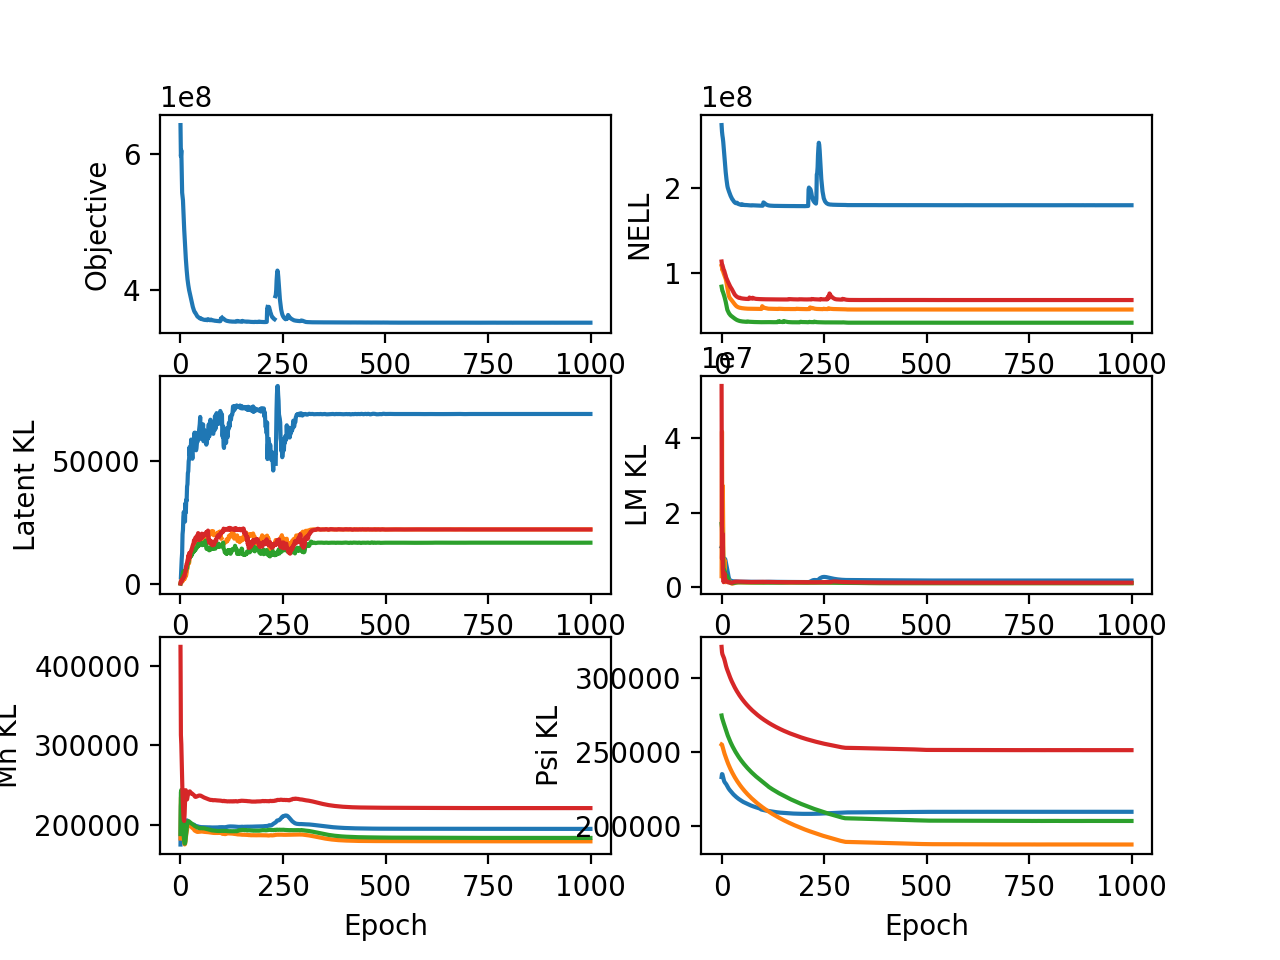

In [19]:
fitter.plot_log(log)

## Orthonormalize our latents

In [20]:
props_conc = torch.cat([locs for locs in neuron_locs.values()], dim=0)
prior_lm_conc = fit_priors.lm_prior(props_conc).detach().numpy()

In [21]:
latents = dict()
for s_n, posteriors_n in fit_posteriors.items():

    latents_n = posteriors_n.latent_post.mns.detach().numpy()
    _, latents_o = orthonormalize(prior_lm_conc, latents_n, unit_len_columns=False )
        
    latents[s_n] = {'latents': latents_n, 'latents_o': latents_o}

## Visualize latents

In [22]:
n_subperiods = len(label_map)
subperiod_clrs = {k: cm.Set1(k_i/(n_subperiods-1)) for k_i, k in enumerate(label_map.keys())}

In [23]:
subperiod_clrs

{'omr_right': (0.8941176470588236,
  0.10196078431372549,
  0.10980392156862745,
  1.0),
 'omr_forward': (1.0, 0.4980392156862745, 0.0, 1.0),
 'omr_left': (0.6, 0.6, 0.6, 1.0)}

In [24]:
subject_markers = {1: 'o', 2: 'v', 5: 's', 6:'X', 8:'o', 9:'o', 10:'o', 11:'o'}

<IPython.core.display.Javascript object>


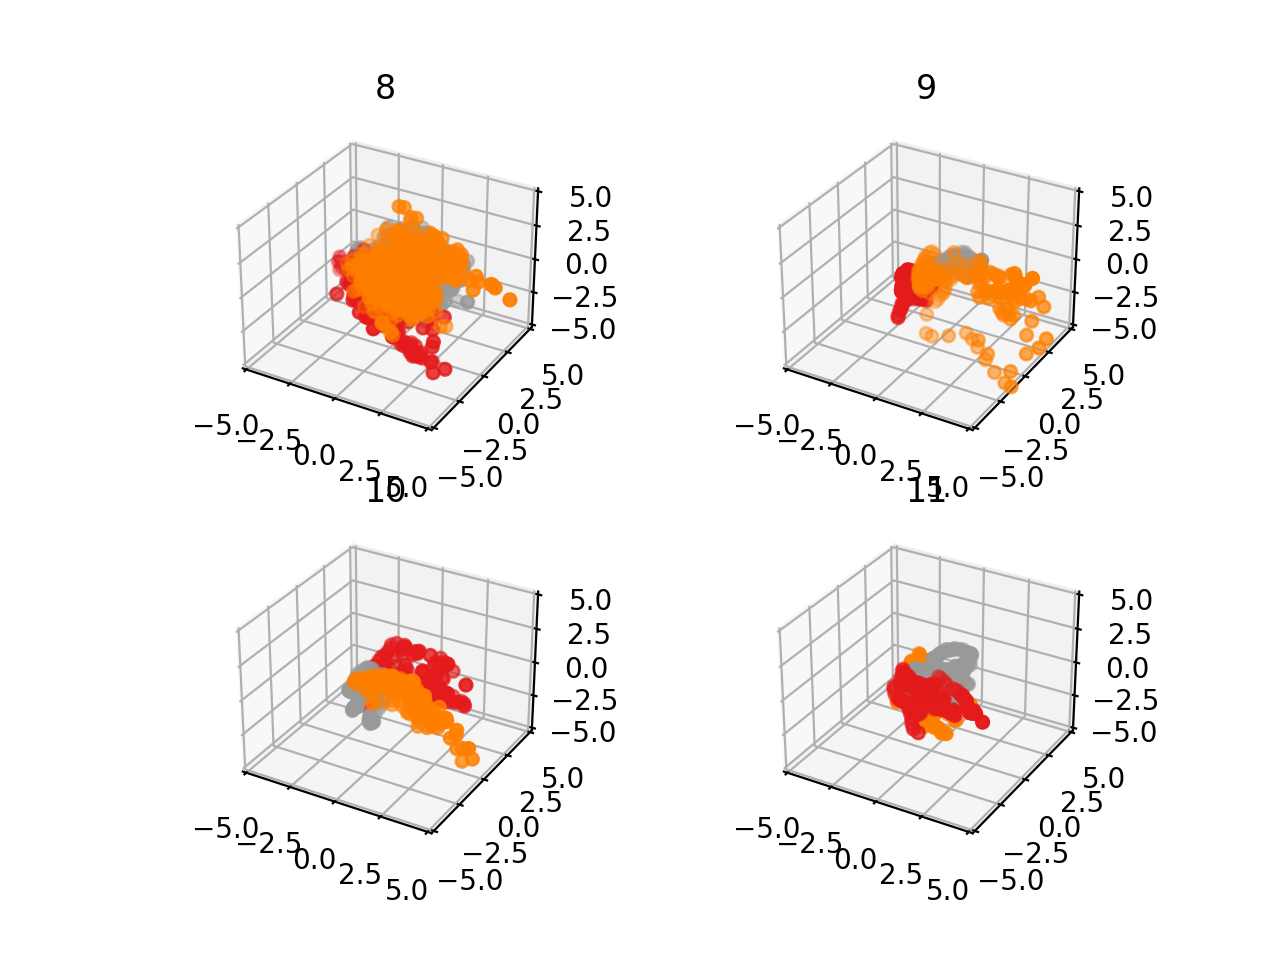

In [37]:
start_dim = 0

plt.figure()
#ax = plt.axes(projection='3d')

for s_i, s_n in enumerate(latents.keys()):
    ax = plt.subplot(2,2, s_i+1, projection='3d')
    plot_latents = latents[s_n]['latents_o']
    plot_labels = fit_labels_conc[s_n]
    
    for sp, sp_lbl in label_map.items():
        sp_clr = subperiod_clrs[sp]
        sp_inds = plot_labels == sp_lbl
        ax.scatter(plot_latents[sp_inds,start_dim+0], plot_latents[sp_inds,start_dim+1], 
                   plot_latents[sp_inds,start_dim+2], color=sp_clr, marker=subject_markers[s_n])
    plt.xlim([-5, 5])
    plt.ylim([-5, 5])
    ax.set_zlim(-5,5)
    plt.title(str(s_n))

In [26]:
subperiod_clrs

{'omr_right': (0.8941176470588236,
  0.10196078431372549,
  0.10980392156862745,
  1.0),
 'omr_forward': (1.0, 0.4980392156862745, 0.0, 1.0),
 'omr_left': (0.6, 0.6, 0.6, 1.0)}

<IPython.core.display.Javascript object>


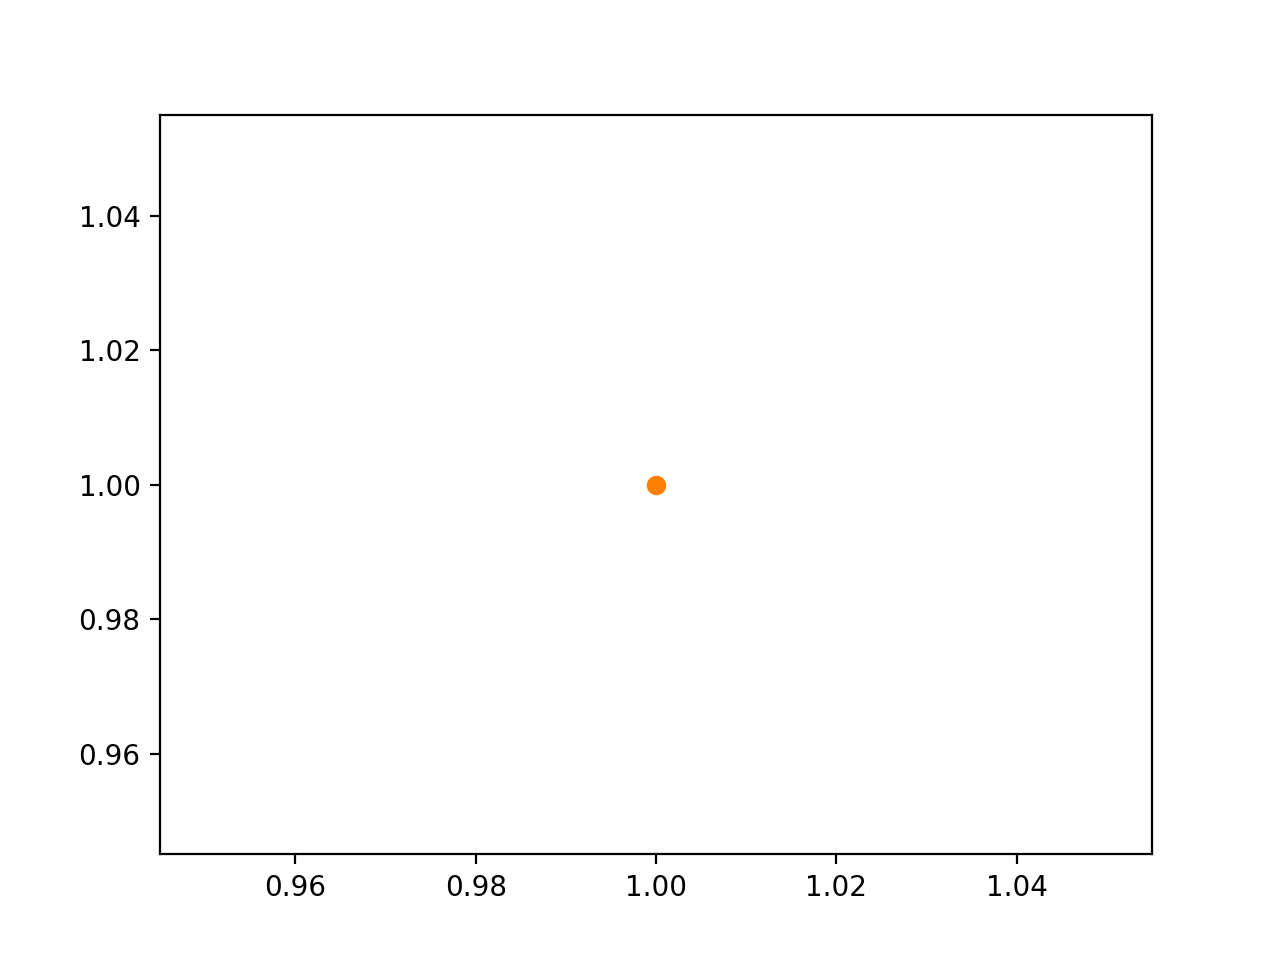

In [27]:
plt.figure()
plt.plot(1, 1, marker='o',color=(1.0, 0.4980392156862745, 0.0, 1.0))

## Visualize loading matrices across space

In [28]:
vis_comp = 1

In [29]:
_, _, o_vis = svd(prior_lm_conc, full_matrices=False)

In [30]:
mode_imgs = dict()
for s_n in subjects:
    neuron_locs_n = neuron_locs[s_n]#.numpy()[:,[0,1]].astype('float')
    
    lm_n = fit_posteriors[s_n].lm_post(neuron_locs_n).detach().numpy()
    lm_n = np.matmul(lm_n, o_vis.transpose())
    
    mode_imgs[s_n], _ = max_project_pts(dot_positions=neuron_locs_n.numpy()[:,[0,1]].astype('float'),
                                        dot_vls=lm_n[:,vis_comp], 
                                        box_position=np.asarray([[0, 0], [990, 610]]), 
                                        n_divisions=np.asarray([990, 610]), 
                                        dot_dim_width=np.asarray([5,5]))
    
    

<IPython.core.display.Javascript object>


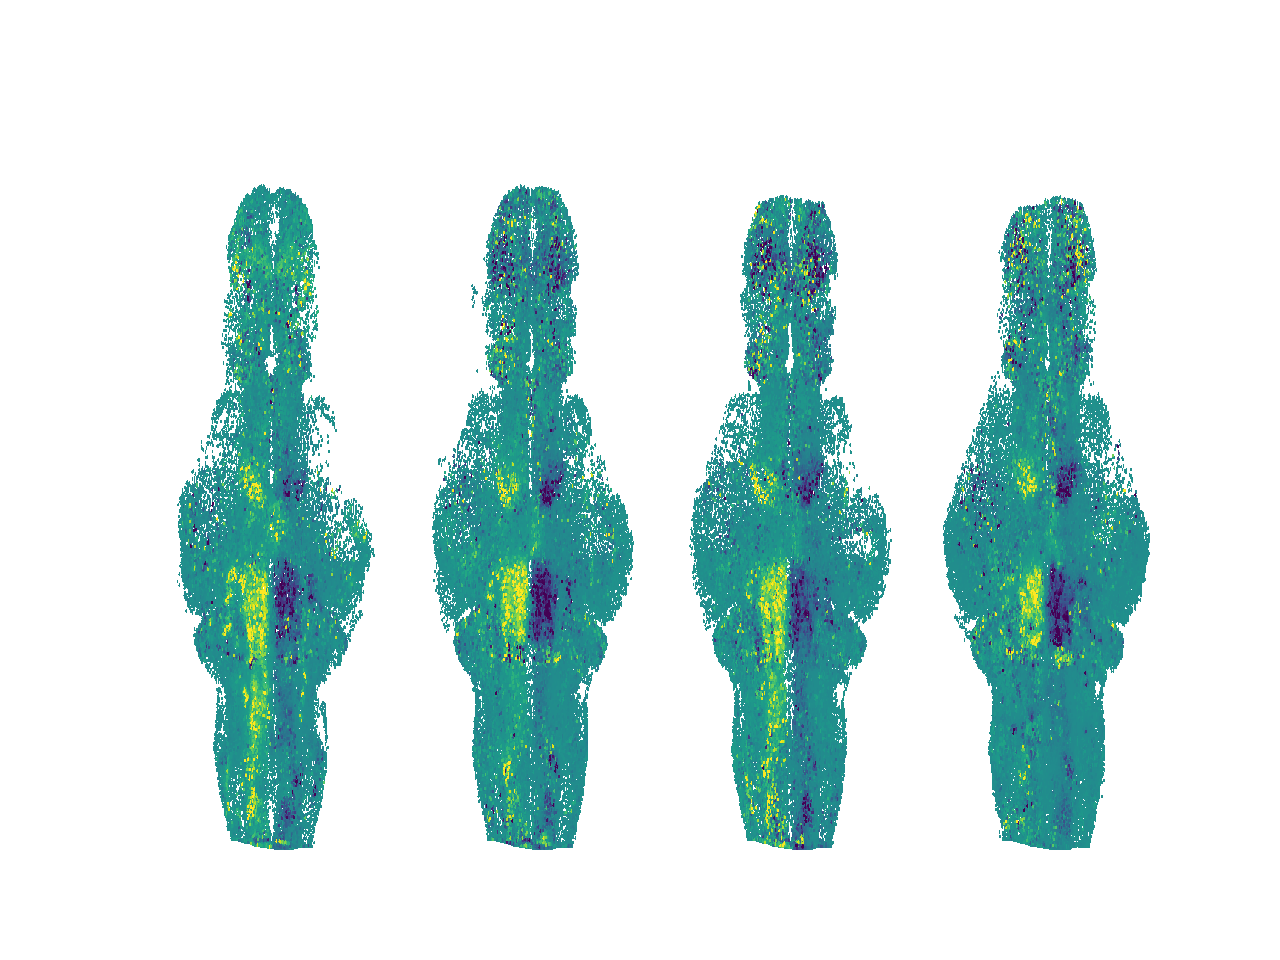

[<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>]

In [31]:
plt.figure()
cmp_n_mats([mode_imgs[k] for k in mode_imgs.keys()], clim=[-2, 2])